In [11]:
%matplotlib notebook 
# Import modules
import math
import numpy as np
import matplotlib.pyplot
import tables as tb
import re

def merge(a,b):
    final = np.zeros (len(a)+len(b))
    for i in range(len(a)):
        final[2*i]   = a[i]
        final[2*i+1] = b[i]
    return final

def elem_aaa(iso):
    m = re.match(r"(?P<letters>[a-zA-Z]+)(?P<the_rest>.+)$", iso)
    return [m.group('letters'), m.group('the_rest')]

def read_iso_m_h5(db_file, iso_list, step):
    db = tb.open_file(db_file, mode='r')
    fuel_bef_mat = db.root.materials.fuel.before_reproc.parameters
    fuel_bef = db.root.materials.fuel.before_reproc.comp
    isomap = fuel_bef.attrs.iso_map

    fuel_after_mat = db.root.materials.fuel.after_reproc.parameters
    fuel_after = db.root.materials.fuel.after_reproc.comp

    mass_b = np.array([x['mass'] for x in fuel_bef_mat.iterrows()])
    vol_b = np.array([x['volume'] for x in fuel_bef_mat.iterrows()])
    dens_b = np.array([x['density'] for x in fuel_bef_mat.iterrows()])

    mass_a = np.array([x['mass'] for x in fuel_after_mat.iterrows()])
    vol_a = np.array([x['volume'] for x in fuel_after_mat.iterrows()])
    dens_a = np.array([x['density'] for x in fuel_after_mat.iterrows()])
    days_b = np.array(step*np.arange(len(mass_b)))
    days_a = np.arange(step, (len(mass_a)+1)*(step), step, dtype=np.float64)

    mass_b = {}
    mass_a = {}
    for iso in iso_list:
        mass_b[iso] = 1e-6*np.array([row[isomap[iso]] for row in fuel_bef])
        mass_a[iso] = 1e-6*np.array([row1[isomap[iso]] for row1 in fuel_after])
    db.close()
    return mass_b, mass_a, days_b # mass in tonnes

def read_feed_h5(db_file, iso_list):
    db = tb.open_file(db_file, mode='r')
    fuel_propert = db.root.materials.fuel.before_reproc.parameters
    fuel_feed = db.root.materials.fuel.in_out_streams.feed_leu
    isomap = fuel_feed.attrs.iso_map
 
    vol = np.array([x['volume'] for x in fuel_propert.iterrows()])
    dens = np.array([x['density'] for x in  fuel_propert.iterrows()])

    mass_feed = 0
    for iso in iso_list:
        mass_feed += 1e-6*np.array([row1[isomap[iso]] for row1 in fuel_feed])
    db.close()
    return mass_feed  # in tonnes

def read_bu_h5(db_file):
    db = tb.open_file(db_file, mode='r')
    fuel_after_param = db.root.materials.fuel.after_reproc.parameters
    bu = np.array([x['burnup'] for x in fuel_after_param.iterrows()])
    db.close()
    
    return sum(bu)

<IPython.core.display.Javascript object>


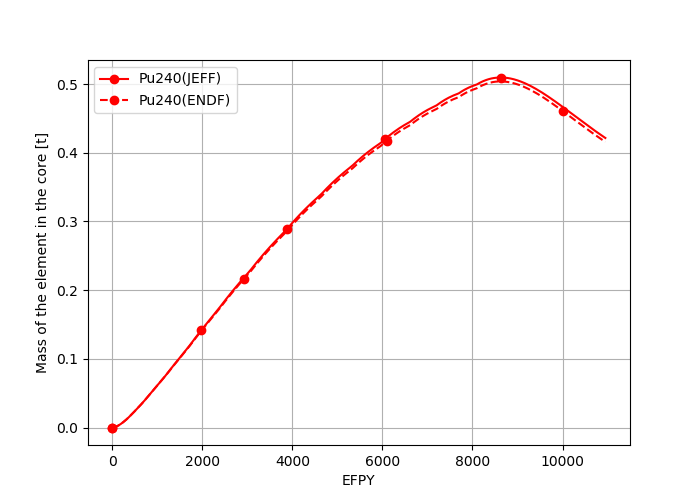

Xe135 before/after 0.000014, 0.000001


In [12]:
import itertools
markers=itertools.cycle(('o','v','s','^','<','>','p','P','*','h','H','+','x','X','D','d','|','_'))
colors=itertools.cycle(('red', 'orange', 'blue', 'green', 'violet', 'black'))

iso_list = ['Xe135', 'Kr83', 'I135','U235', 'U236','U237', 'U238',
            'Np235', 'Np236', 'Np237', 'Np238', 'Np239',
            'Pu236', 'Pu237', 'Pu238', 'Pu239', 'Pu240', 'Pu241', 'Pu242', 'Pu243', 'Pu244',
            'Am241', 'Am242', 'Am242m1', 'Am243', 'Am244', 'Am244m1',
            'Cm240', 'Cm241', 'Cm242', 'Cm243', 'Cm244', 'Cm245', 'Cm246', 'Cm247', 'Cm248', 'Cm249', 'Cm250',
            'Sm149', 'Mo95', 'Te135', 'Nd143', 'Pm147', 'H2', 'H3']
#plot_iso = ['U235', 'U236', 'U238','Pu239', 'Pu240', 'Pu242', 'Pu241']
plot_iso = ['Pu240']


db_file_jeff = '/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/data/db/3d_10950d_jeff.h5'

db_file_endf = '/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/data/db/3d_10950d_endf_s(ab).h5'



mass_before_5, mass_after_5, t_5 = read_iso_m_h5(db_file_jeff, iso_list,3.0)
mass_before_7_5, mass_after_7_5, t_7_5 = read_iso_m_h5(db_file_endf, iso_list, 3.0)

# Initialize figure
fig_1 = matplotlib.pyplot.figure(1, figsize=[7,5])
ax = fig_1.add_subplot(111)
ax.grid(True)
eps = {'Xe135':0.988, 'I135':0.05}

for i in plot_iso:
    m=next(markers)
    c=next(colors)
    ax.plot(t_5, mass_before_5[i], '-',marker=m, markevery=0.2, label=str(i)+"(JEFF)", color=c)
    ax.plot(t_7_5, mass_before_7_5[i], '--',marker=m, markevery=0.3, label=str(i)+"(ENDF)", color=c)
ax.legend(loc=0)
#ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.set_ylabel('Mass of the element in the core [t]')
ax.set_xlabel('EFPY')
#ax.set_title('Multiplication factor for online reprocessing case ' + str(EOS) +' days')
#ax.set_xlim(0, 13)
#ax.set_ylim(2e-1, 3e+1)
#ax.set_ylim(2e-1, 7.5e+4)
fig_1.show()

#fig_1.savefig('/home/andrei2/Desktop/git/meitner-task-2/doc/2019-06-q4-report/figures/u_pu_mass.png',bbox_inches='tight', dpi=700)
#xe_step_removal = (mass_b['Xe135'][1:] - mass_a['Xe135'])/mass_b['Xe135'][1:]
#i_step_removal = (mass_b['I135'][1:] - mass_a['I135'])/mass_b['I135'][1:]
# print("Xe-135 removal efficiency ", xe_step_removal)
# print("I-135 removal efficiency ", i_step_removal)
#print('U238 dynamics %f, %f' %(1e-6*mass_a['U238'][0],1e-6*mass_a['U238'][-1]))
print('Xe135 before/after %f, %f' %(mass_before_5['Xe135'][-1],mass_after_5['Xe135'][-1]))

3651 3651


<IPython.core.display.Javascript object>


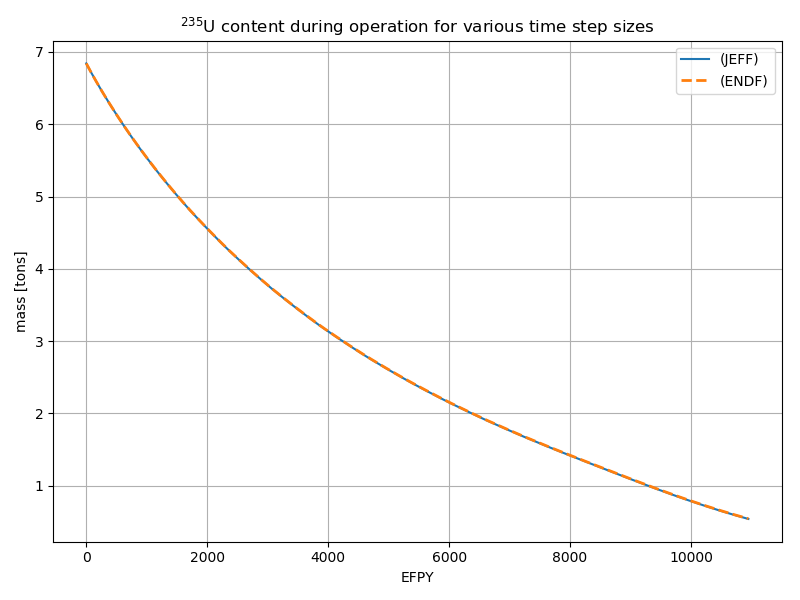

In [13]:
#print(t_5[:5], t_7_5[:4]/1.5)
print(len(t_5), len(t_7_5))
# Initialize figure
fig_u235_mass = matplotlib.pyplot.figure(2, figsize=[8,6])
ax1 = fig_u235_mass.subplots()
ax1.grid(True)
ax1.plot(t_5, mass_before_5['U235'], '-', label='(JEFF)', linewidth=1.5) # at BDS (feed LEU 19.79%)
ax1.plot(t_7_5, mass_before_7_5['U235'], '--', label='(ENDF)', linewidth=2.0) # at BDS (feed LEU 19.79%)
ax1.legend(loc=0)
ax1.set_ylabel(r'mass [tons]')
ax1.set_xlabel('EFPY')
ax1.set_title(r'$^{235}$U content during operation for various time step sizes')
#ax1.set_xlim(12,12.25)
#ax1.set_xlim(0,13)
#ax1.set_ylim([2.85, 2.93])

#ax2 = ax1.twinx()
#ax2.set_prop_cycle(color=colors[1:])
#ax2.set_ylabel(r'$\Delta k$ from $\Delta t = 5d$ [%]')
#ax2.plot(days_7_5d[:-15], 1e+5*(k_bds_2_5d[::3] - k_bds_7_5d[:-15]), '--', label='7.5d', linewidth=0.7)
#ax2.plot(days_15d[:-69], 1e+5*(k_bds_2_5d[::6] - k_bds_15d[:-69]), '--', label='15d', linewidth=0.7)
#ax2.plot(days_30d[:-11], 1e+5*(k_bds_2_5d[::12] - k_bds_30d[:-11]), '--', label='30d', linewidth=0.7)
#ax2.legend(loc=1)
#ax2.set_ylim(-10, 2000)

fig_u235_mass.tight_layout()
fig_u235_mass.show()

#print(mass_before_5['U236'])
#print(mass_before_7_5['U236'])

<IPython.core.display.Javascript object>


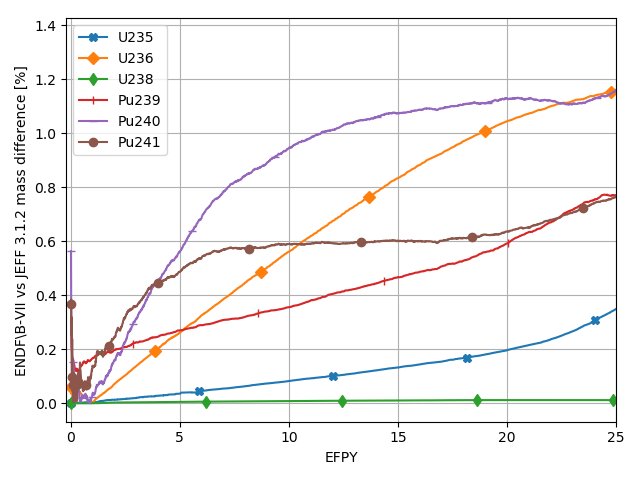

In [21]:
plot_iso = ['U235', 'U236', 'U238','Pu239', 'Pu240', 'Pu241']
#plot_iso = ['U235', 'U238', 'Xe135', 'I135']
#plot_iso = ['I135', 'Xe135', 'Kr83']

# Initialize figure
fig_diff = matplotlib.pyplot.figure(3)
ax = fig_diff.add_subplot(111)
ax.grid(True)

for i in plot_iso:
    m=next(markers)
    el_aaa = elem_aaa(i)
    k_name = "$^{"+str(el_aaa[-1])+"}$"+str(el_aaa[0])
    #print(k_name)
    #ax.semilogy(t_5, mass_before_5[i], '-',marker=m, markevery=0.2, label=str(i)+"(JEFF-3.1.2)")
    #ax.semilogy(t_7_5, mass_before_7_5[i], '--',marker=m, markevery=0.3, label=str(i)+"(ENDFB-VII)")
    ax.plot(t_7_5[2:]/365.0, 100*abs(mass_after_5[i][1:]-mass_after_7_5[i][1:])/mass_after_5[i][1:], '-',marker=m, markevery=0.2, label=str(i))
    #ax.plot(t_7_5[1:]/365.0, 1e6*abs(mass_before_5[i][1:]-mass_before_7_5[i][1:]),
    #            '-', label=k_name)  # marker=m, markevery=0.2, 
ax.legend(loc=0)
#ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#ax.set_ylabel(r'$\mid \frac{m_{endf}-m_{jeff}}{m_{jeff}}\mid\times 100$ [%]')
ax.set_ylabel(r'ENDF\B-VII vs JEFF 3.1.2 mass difference [%]')
ax.set_xlabel('EFPY')
#ax.set_title('Multiplication factor for online reprocessing case ' + str(EOS) +' days')
ax.set_xlim(-0.2, 25)
#ax.set_ylim(2e-1, 3e+1)
#ax.set_ylim(2e-1, 7.5e+4)
fig_diff.tight_layout()
fig_diff.show()
#fig_diff.savefig('/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/dissertation/figures/endf_jeff_u_pu_diff.png',bbox_inches='tight', dpi=700)

<IPython.core.display.Javascript object>


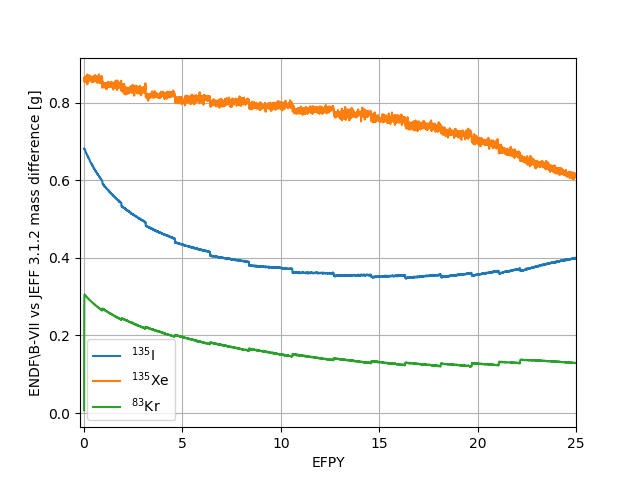

In [20]:
plot_iso = ['I135', 'Xe135', 'Kr83']
#plot_iso = ['Xe135']
# Initialize figure
fig_diff_2 = matplotlib.pyplot.figure(4)
ax = fig_diff_2.add_subplot(111)
ax.grid(True)

for i in plot_iso:
    m=next(markers)
    el_aaa = elem_aaa(i)
    k_name = "$^{"+str(el_aaa[-1])+"}$"+str(el_aaa[0])
    #print(k_name)
    #ax.plot(t_5, mass_before_5[i], '-',marker=m, markevery=0.2, label=str(i)+"(JEFF-3.1.2)")
    #ax.plot(t_7_5, mass_before_7_5[i], '--',marker=m, markevery=0.3, label=str(i)+"(ENDFB-VII)")
    #ax.plot(t_7_5[2:]/365.0, 100*abs(mass_before_5[i][2:]-mass_before_7_5[i][2:])/mass_before_5[i][2:], '-',marker=m, markevery=0.2, label=str(i))
    ax.plot(t_7_5[1:]/365.0, 1e6*abs(mass_before_5[i][1:]-mass_before_7_5[i][1:]),
                '-', label=k_name)  # marker=m, markevery=0.2, 
ax.legend(loc=0)
#ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#ax.set_ylabel(r'$\mid \frac{m_{endf}-m_{jeff}}{m_{jeff}}\mid\times 100$ [%]')
ax.set_ylabel(r'ENDF\B-VII vs JEFF 3.1.2 mass difference [g]')
ax.set_xlabel('EFPY')
#ax.set_title('Multiplication factor for online reprocessing case ' + str(EOS) +' days')
ax.set_xlim(-0.2, 25)
#ax.set_ylim(2e-1, 3e+1)
#ax.set_ylim(2e-1, 7.5e+4)
fig_diff_2.show()
#fig_diff_2.savefig('/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/dissertation/figures/endf_jeff_pois_diff.png',bbox_inches='tight', dpi=700)

<IPython.core.display.Javascript object>


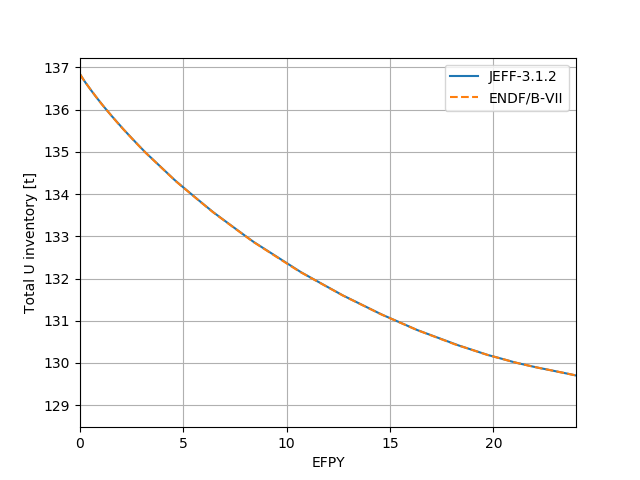

<IPython.core.display.Javascript object>


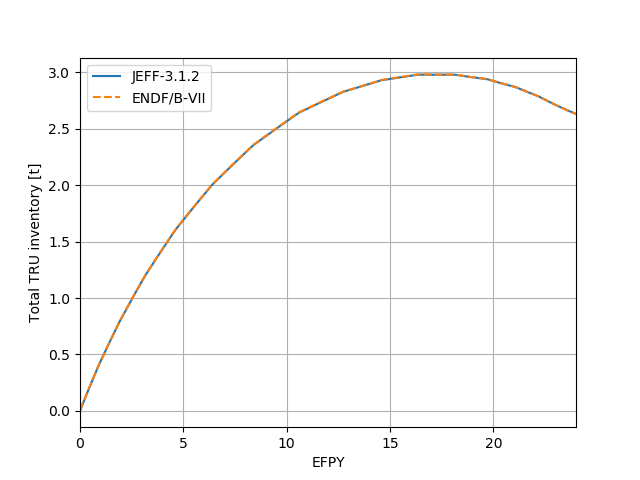

<IPython.core.display.Javascript object>


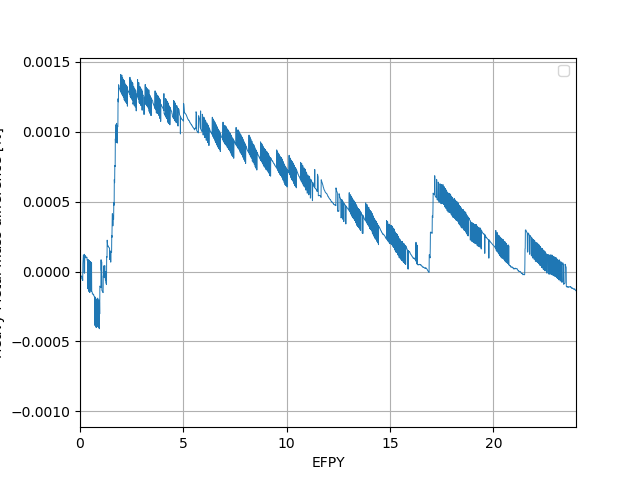

No handles with labels found to put in legend.


Total U diff. at the EOL -0.005375 t
Total Pu diff. at the EOL 0.025232 t
Total TRU diff. at the EOL 0.004615 t
Total HM diff. at the EOL -0.760146 kg


In [18]:
u_iso = ['U235', 'U236', 'U237', 'U238']
pu_iso = ['Pu236', 'Pu237', 'Pu238', 'Pu239', 'Pu240', 'Pu241', 'Pu242', 'Pu243', 'Pu244']
tru_iso = ['Np235', 'Np236', 'Np237', 'Np238', 'Np239',
           'Pu236', 'Pu237', 'Pu238', 'Pu239', 'Pu240', 'Pu241', 'Pu242', 'Pu243', 'Pu244',
           'Am241', 'Am242', 'Am242m1', 'Am243', 'Am244', 'Am244m1',
           'Cm240', 'Cm241', 'Cm242', 'Cm243', 'Cm244', 'Cm245', 'Cm246', 'Cm247', 'Cm248', 'Cm249', 'Cm250']

m_u_jeff = np.zeros_like(mass_before_5['U238'][1:])
m_pu_jeff = np.zeros_like(m_u_jeff)
m_tru_jeff = np.zeros_like(m_u_jeff)

m_u_endf = np.zeros_like(mass_before_7_5['U238'][1:])
m_pu_endf = np.zeros_like(m_u_endf)
m_tru_endf = np.zeros_like(m_u_endf)

for i in u_iso:
    m_u_jeff = np.add(m_u_jeff, mass_before_5[i][1:])
    m_u_endf = np.add(m_u_endf, mass_before_7_5[i][1:])
for i in pu_iso:
    m_pu_jeff = np.add(m_pu_jeff, mass_before_5[i][1:])
    m_pu_endf = np.add(m_pu_endf, mass_before_7_5[i][1:])
for i in tru_iso:
    m_tru_jeff = np.add(m_tru_jeff, mass_before_5[i][1:])
    m_tru_endf = np.add(m_tru_endf, mass_before_7_5[i][1:])

# Total Heavy Metal
m_hm_jeff = m_u_jeff + m_tru_jeff
m_hm_endf = m_u_endf + m_tru_endf

# Initialize figure
fig_diff_u = matplotlib.pyplot.figure(5)
ax = fig_diff_u.add_subplot(111)
ax.grid(True)
  
ax.plot(t_5[1:]/365.0, (m_u_jeff), '-', markevery=0.2, label='JEFF-3.1.2')
ax.plot(t_7_5[1:]/365.0, (m_u_endf), '--', markevery=0.2, label='ENDF/B-VII')
ax.legend(loc=0)
#ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#ax.set_ylabel(r'$\mid \frac{m_{endf}-m_{jeff}}{m_{jeff}}\mid\times 100$ [%]')
ax.set_ylabel(r'Total U inventory [t]')
ax.set_xlabel('EFPY')
#ax.set_title('Multiplication factor for online reprocessing case ' + str(EOS) +' days')
ax.set_xlim(0, 24)
#ax.set_ylim(2e-1, 3e+1)
#ax.set_ylim(2e-1, 7.5e+4)
fig_diff_u.show()
#fig_diff_u.savefig('/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/dissertation/figures/endf_jeff_total_u_diff.png',bbox_inches='tight', dpi=700)

# Initialize figure
fig_diff_pu = matplotlib.pyplot.figure(6)
ax = fig_diff_pu.add_subplot(111)
ax.grid(True)
  
ax.plot(t_5[1:]/365.0, (m_tru_jeff), '-', markevery=0.2, label='JEFF-3.1.2')
ax.plot(t_7_5[1:]/365.0, (m_tru_endf), '--', markevery=0.2, label='ENDF/B-VII')
ax.legend(loc=0)
#ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#ax.set_ylabel(r'$\mid \frac{m_{endf}-m_{jeff}}{m_{jeff}}\mid\times 100$ [%]')
ax.set_ylabel(r'Total TRU inventory [t]')
ax.set_xlabel('EFPY')
#ax.set_title('Multiplication factor for online reprocessing case ' + str(EOS) +' days')
ax.set_xlim(0, 24)
#ax.set_ylim(2e-1, 3e+1)
#ax.set_ylim(2e-1, 7.5e+4)
fig_diff_pu.show()
#fig_diff_pu.savefig('/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/dissertation/figures/endf_jeff_total_tru_diff.png',bbox_inches='tight', dpi=700)

# Initialize figure
fig_diff_hm = matplotlib.pyplot.figure(7)
ax = fig_diff_hm.add_subplot(111)
ax.grid(True)
  
ax.plot(t_5[1:]/365.0, 100*(m_hm_jeff-m_hm_endf)/m_hm_jeff, '-', linewidth=0.7)
#ax.plot(t_7_5[1:]/365.0, (m_hm_endf), '--', markevery=0.2)
ax.legend(loc=0)
#ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#ax.set_ylabel(r'$\mid \frac{m_{endf}-m_{jeff}}{m_{jeff}}\mid\times 100$ [%]')
ax.set_ylabel(r'Heavy Metal mass difference [%]')
ax.set_xlabel('EFPY')
#ax.set_title('Multiplication factor for online reprocessing case ' + str(EOS) +' days')
ax.set_xlim(0, 24)
#ax.set_ylim(2e-1, 3e+1)
#ax.set_ylim(2e-1, 7.5e+4)
fig_diff_hm.show()
#fig_diff_hm.savefig('/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/dissertation/figures/endf_jeff_total_hm_rel_diff.png',bbox_inches='tight', dpi=700)

print("Total U diff. at the EOL %f t"  %(m_u_jeff[-1]-m_u_endf[-1]))
print("Total Pu diff. at the EOL %f t" %(m_pu_jeff[-1]-m_pu_endf[-1]))
print("Total TRU diff. at the EOL %f t" %(m_tru_jeff[-1]-m_tru_endf[-1]))
print("Total HM diff. at the EOL %f kg" %( 1e3*(m_tru_jeff[-1]+m_u_jeff[-1]) - \
                                           1e3*(m_tru_endf[-1]+m_u_endf[-1])))

## Calculate LEU fuel feed rate (from Betzler ~480 kg/year)

In [16]:
feed_iso = ['U235', 'U238', 'F19', 'Li6', 'Li7']

feed_mass = read_feed_h5(db_file_jeff, feed_iso)

print("JEFF-3.1.2 case")
print("Total mass of LEU salt feeded over %i years is %f t" % (t_5[-1]/365, sum(feed_mass)))
for i in range(int(3.0*len(t_5)/365.0)):
    print("LEU feed rate during %i year %f kg/year" % (i, 1e3*sum(feed_mass[i*121:(i+1)*121])))
print("LEU avarage feed rate %f kg/year" % (1e3*sum(feed_mass/(t_5[-1]/365))))
print("Total burnup %f MWd/kgU" %read_bu_h5(db_file_jeff))

JEFF-3.1.2 case
Total mass of LEU salt feeded over 30 years is 13.933361 t
LEU feed rate during 0 year 378.262488 kg/year
LEU feed rate during 1 year 451.557124 kg/year
LEU feed rate during 2 year 463.766795 kg/year
LEU feed rate during 3 year 466.930261 kg/year
LEU feed rate during 4 year 467.524636 kg/year
LEU feed rate during 5 year 467.361618 kg/year
LEU feed rate during 6 year 467.172741 kg/year
LEU feed rate during 7 year 466.755783 kg/year
LEU feed rate during 8 year 466.586160 kg/year
LEU feed rate during 9 year 466.196510 kg/year
LEU feed rate during 10 year 466.051094 kg/year
LEU feed rate during 11 year 465.767208 kg/year
LEU feed rate during 12 year 465.578572 kg/year
LEU feed rate during 13 year 465.387620 kg/year
LEU feed rate during 14 year 465.242598 kg/year
LEU feed rate during 15 year 465.058841 kg/year
LEU feed rate during 16 year 464.990950 kg/year
LEU feed rate during 17 year 464.765204 kg/year
LEU feed rate during 18 year 464.740620 kg/year
LEU feed rate during 19

In [17]:
feed_mass_endf = read_feed_h5(db_file_endf, feed_iso)

print("ENDF/B-VII with S(a,b) from JEFF-3.1.2 case")
print("Total mass of LEU salt feeded over %i years is %f t" % (t_7_5[-1]/365, sum(feed_mass_endf)))
for i in range(int(3.0*len(t_7_5)/365.0)):
    print("LEU feed rate during %i year %f kg/year" % (i, 1e3*sum(feed_mass_endf[i*121:(i+1)*121])))
print("LEU avarage feed rate %f kg/year" % (1e3*sum(feed_mass_endf/(t_7_5[-1]/365))))
print("Total burnup %f MWd/kgU" %read_bu_h5(db_file_endf))

ENDF/B-VII with S(a,b) from JEFF-3.1.2 case
Total mass of LEU salt feeded over 30 years is 13.853553 t
LEU feed rate during 0 year 375.209441 kg/year
LEU feed rate during 1 year 448.708256 kg/year
LEU feed rate during 2 year 460.997483 kg/year
LEU feed rate during 3 year 464.181095 kg/year
LEU feed rate during 4 year 464.774551 kg/year
LEU feed rate during 5 year 464.614321 kg/year
LEU feed rate during 6 year 464.433589 kg/year
LEU feed rate during 7 year 464.018943 kg/year
LEU feed rate during 8 year 463.864760 kg/year
LEU feed rate during 9 year 463.485596 kg/year
LEU feed rate during 10 year 463.355389 kg/year
LEU feed rate during 11 year 463.082716 kg/year
LEU feed rate during 12 year 462.902762 kg/year
LEU feed rate during 13 year 462.733437 kg/year
LEU feed rate during 14 year 462.606610 kg/year
LEU feed rate during 15 year 462.438534 kg/year
LEU feed rate during 16 year 462.384684 kg/year
LEU feed rate during 17 year 462.168712 kg/year
LEU feed rate during 18 year 462.156553 kg/

In [ ]:
from pyne import nucname
from collections import OrderedDict 

print(nucname.id('Li7'))

iso = OrderedDict([('H1', 0), ('H2', 1), ('H3', 2), ('He3', 3), ('He4', 4), ('He6', 5), ('He8', 6), ('Li6', 7), ('Li7', 8), ('Li8', 9), ('Li9', 10), ('Be6', 11), ('Be8', 12), ('Be9', 13), ('Be10', 14), ('Be11', 15), ('Be12', 16), ('B9', 17), ('B10', 18), ('B11', 19), ('B12', 20), ('C8', 21), ('C12', 22), ('C13', 23), ('C14', 24), ('C15', 25), ('N13', 26), ('N14', 27), ('N15', 28), ('N16', 29), ('N17', 30), ('O15', 31), ('O16', 32), ('O17', 33), ('O18', 34), ('O19', 35), ('F18', 36), ('F19', 37), ('F20', 38), ('Ne20', 39), ('Ne21', 40), ('Ne22', 41), ('Ne23', 42), ('Na21', 43), ('Na22', 44), ('Na23', 45), ('Na24', 46), ('Na24m1', 47), ('Na25', 48), ('Na26', 49), ('Mg23', 50), ('Mg24', 51), ('Mg25', 52), ('Mg26', 53), ('Mg27', 54), ('Mg28', 55), ('Mg29', 56), ('Al26', 57), ('Al27', 58), ('Al28', 59), ('Al29', 60), ('Al30', 61), ('Si27', 62), ('Si28', 63), ('Si29', 64), ('Si30', 65), ('Si31', 66), ('Si32', 67), ('Si33', 68), ('P30', 69), ('P31', 70), ('P32', 71), ('P33', 72), ('P34', 73), ('P35', 74), ('P36', 75), ('S32', 76), ('S33', 77), ('S34', 78), ('S35', 79), ('S36', 80), ('S37', 81), ('Cl34', 82), ('Cl35', 83), ('Cl36', 84), ('Cl37', 85), ('Cl38', 86), ('Cl38m1', 87), ('Cl39', 88), ('Cl40', 89), ('Ar36', 90), ('Ar37', 91), ('Ar38', 92), ('Ar39', 93), ('Ar40', 94), ('Ar41', 95), ('Ar42', 96), ('K38', 97), ('K39', 98), ('K40', 99), ('K41', 100), ('K42', 101), ('K43', 102), ('K44', 103), ('K50', 104), ('K51', 105), ('Ca40', 106), ('Ca41', 107), ('Ca42', 108), ('Ca43', 109), ('Ca44', 110), ('Ca45', 111), ('Ca46', 112), ('Ca47', 113), ('Ca48', 114), ('Ca49', 115), ('Ca50', 116), ('Ca51', 117), ('Ca52', 118), ('Ca53', 119), ('Ca54', 120), ('Sc44', 121), ('Sc45', 122), ('Sc45m1', 123), ('Sc46', 124), ('Sc46m1', 125), ('Sc47', 126), ('Sc48', 127), ('Sc49', 128), ('Sc50', 129), ('Sc50m1', 130), ('Sc51', 131), ('Sc52', 132), ('Sc53', 133), ('Sc54', 134), ('Sc55', 135), ('Sc56', 136), ('Sc57', 137), ('Ti45', 138), ('Ti46', 139), ('Ti47', 140), ('Ti48', 141), ('Ti49', 142), ('Ti50', 143), ('Ti51', 144), ('Ti52', 145), ('Ti53', 146), ('Ti54', 147), ('Ti55', 148), ('Ti56', 149), ('Ti57', 150), ('Ti58', 151), ('Ti59', 152), ('Ti60', 153), ('Ti61', 154), ('V49', 155), ('V50', 156), ('V51', 157), ('V52', 158), ('V53', 159), ('V54', 160), ('V55', 161), ('V56', 162), ('V57', 163), ('V58', 164), ('V59', 165), ('V60', 166), ('V61', 167), ('V62', 168), ('V63', 169), ('V64', 170), ('V65', 171), ('Cr49', 172), ('Cr50', 173), ('Cr51', 174), ('Cr52', 175), ('Cr53', 176), ('Cr54', 177), ('Cr55', 178), ('Cr56', 179), ('Cr57', 180), ('Cr58', 181), ('Cr59', 182), ('Cr60', 183), ('Cr61', 184), ('Cr62', 185), ('Cr63', 186), ('Cr64', 187), ('Cr65', 188), ('Cr66', 189), ('Cr67', 190), ('Mn52', 191), ('Mn53', 192), ('Mn54', 193), ('Mn55', 194), ('Mn56', 195), ('Mn57', 196), ('Mn58', 197), ('Mn58m1', 198), ('Mn59', 199), ('Mn60', 200), ('Mn60m1', 201), ('Mn61', 202), ('Mn62', 203), ('Mn62m1', 204), ('Mn63', 205), ('Mn64', 206), ('Mn65', 207), ('Mn66', 208), ('Mn67', 209), ('Mn68', 210), ('Mn69', 211), ('Fe53', 212), ('Fe54', 213), ('Fe55', 214), ('Fe56', 215), ('Fe57', 216), ('Fe58', 217), ('Fe59', 218), ('Fe60', 219), ('Fe61', 220), ('Fe62', 221), ('Fe63', 222), ('Fe64', 223), ('Fe65', 224), ('Fe66', 225), ('Fe67', 226), ('Fe68', 227), ('Fe69', 228), ('Fe70', 229), ('Fe71', 230), ('Fe72', 231), ('Co56', 232), ('Co57', 233), ('Co58', 234), ('Co59', 235), ('Co60', 236), ('Co60m1', 237), ('Co61', 238), ('Co62', 239), ('Co62m1', 240), ('Co63', 241), ('Co64', 242), ('Co65', 243), ('Co66', 244), ('Co67', 245), ('Co68', 246), ('Co68m1', 247), ('Co69', 248), ('Co70', 249), ('Co70m1', 250), ('Co71', 251), ('Co72', 252), ('Co73', 253), ('Co74', 254), ('Co75', 255), ('Ni57', 256), ('Ni58', 257), ('Ni59', 258), ('Ni60', 259), ('Ni61', 260), ('Ni62', 261), ('Ni63', 262), ('Ni64', 263), ('Ni65', 264), ('Ni66', 265), ('Ni67', 266), ('Ni68', 267), ('Ni69', 268), ('Ni69m1', 269), ('Ni70', 270), ('Ni71', 271), ('Ni72', 272), ('Ni73', 273), ('Ni74', 274), ('Ni75', 275), ('Ni76', 276), ('Ni77', 277), ('Ni78', 278), ('Cu63', 279), ('Cu64', 280), ('Cu65', 281), ('Cu66', 282), ('Cu67', 283), ('Cu68', 284), ('Cu68m1', 285), ('Cu69', 286), ('Cu70', 287), ('Cu70m1', 288), ('Cu71', 289), ('Cu72', 290), ('Cu73', 291), ('Cu74', 292), ('Cu75', 293), ('Cu76', 294), ('Cu76m1', 295), ('Cu77', 296), ('Cu78', 297), ('Cu79', 298), ('Cu80', 299), ('Zn64', 300), ('Zn65', 301), ('Zn66', 302), ('Zn67', 303), ('Zn68', 304), ('Zn69', 305), ('Zn69m1', 306), ('Zn70', 307), ('Zn71', 308), ('Zn71m1', 309), ('Zn72', 310), ('Zn73', 311), ('Zn73m1', 312), ('Zn74', 313), ('Zn75', 314), ('Zn76', 315), ('Zn77', 316), ('Zn77m1', 317), ('Zn78', 318), ('Zn79', 319), ('Zn80', 320), ('Zn81', 321), ('Zn82', 322), ('Zn83', 323), ('Ga68', 324), ('Ga69', 325), ('Ga70', 326), ('Ga71', 327), ('Ga72', 328), ('Ga72m1', 329), ('Ga73', 330), ('Ga74', 331), ('Ga74m1', 332), ('Ga75', 333), ('Ga76', 334), ('Ga77', 335), ('Ga78', 336), ('Ga79', 337), ('Ga80', 338), ('Ga81', 339), ('Ga82', 340), ('Ga83', 341), ('Ga84', 342), ('Ga85', 343), ('Ga86', 344), ('Ge69', 345), ('Ge70', 346), ('Ge71', 347), ('Ge71m1', 348), ('Ge72', 349), ('Ge73', 350), ('Ge73m1', 351), ('Ge74', 352), ('Ge75', 353), ('Ge75m1', 354), ('Ge76', 355), ('Ge77', 356), ('Ge77m1', 357), ('Ge78', 358), ('Ge79', 359), ('Ge79m1', 360), ('Ge80', 361), ('Ge81', 362), ('Ge81m1', 363), ('Ge82', 364), ('Ge83', 365), ('Ge84', 366), ('Ge85', 367), ('Ge86', 368), ('Ge87', 369), ('Ge88', 370), ('Ge89', 371), ('As73', 372), ('As74', 373), ('As75', 374), ('As75m1', 375), ('As76', 376), ('As77', 377), ('As78', 378), ('As79', 379), ('As80', 380), ('As81', 381), ('As82', 382), ('As82m1', 383), ('As83', 384), ('As84', 385), ('As84m1', 386), ('As85', 387), ('As86', 388), ('As87', 389), ('As88', 390), ('As89', 391), ('As90', 392), ('As91', 393), ('Se74', 394), ('Se75', 395), ('Se76', 396), ('Se77', 397), ('Se77m1', 398), ('Se78', 399), ('Se79', 400), ('Se79m1', 401), ('Se80', 402), ('Se81', 403), ('Se81m1', 404), ('Se82', 405), ('Se83', 406), ('Se83m1', 407), ('Se84', 408), ('Se85', 409), ('Se86', 410), ('Se87', 411), ('Se88', 412), ('Se89', 413), ('Se90', 414), ('Se91', 415), ('Se92', 416), ('Se93', 417), ('Se94', 418), ('Br78', 419), ('Br79', 420), ('Br79m1', 421), ('Br80', 422), ('Br80m1', 423), ('Br81', 424), ('Br82', 425), ('Br82m1', 426), ('Br83', 427), ('Br84', 428), ('Br84m1', 429), ('Br85', 430), ('Br86', 431), ('Br87', 432), ('Br88', 433), ('Br89', 434), ('Br90', 435), ('Br91', 436), ('Br92', 437), ('Br93', 438), ('Br94', 439), ('Br95', 440), ('Br96', 441), ('Kr79', 442), ('Kr80', 443), ('Kr81', 444), ('Kr81m1', 445), ('Kr82', 446), ('Kr83', 447), ('Kr83m1', 448), ('Kr84', 449), ('Kr85', 450), ('Kr85m1', 451), ('Kr86', 452), ('Kr87', 453), ('Kr88', 454), ('Kr89', 455), ('Kr90', 456), ('Kr91', 457), ('Kr92', 458), ('Kr93', 459), ('Kr94', 460), ('Kr95', 461), ('Kr96', 462), ('Kr97', 463), ('Kr98', 464), ('Kr99', 465), ('Rb83', 466), ('Rb83m1', 467), ('Rb84', 468), ('Rb84m1', 469), ('Rb85', 470), ('Rb86', 471), ('Rb86m1', 472), ('Rb87', 473), ('Rb88', 474), ('Rb89', 475), ('Rb90', 476), ('Rb90m1', 477), ('Rb91', 478), ('Rb92', 479), ('Rb93', 480), ('Rb94', 481), ('Rb95', 482), ('Rb96', 483), ('Rb96m1', 484), ('Rb97', 485), ('Rb98', 486), ('Rb98m1', 487), ('Rb99', 488), ('Rb100', 489), ('Rb101', 490), ('Sr84', 491), ('Sr85', 492), ('Sr85m1', 493), ('Sr86', 494), ('Sr87', 495), ('Sr87m1', 496), ('Sr88', 497), ('Sr89', 498), ('Sr90', 499), ('Sr91', 500), ('Sr92', 501), ('Sr93', 502), ('Sr94', 503), ('Sr95', 504), ('Sr96', 505), ('Sr97', 506), ('Sr98', 507), ('Sr99', 508), ('Sr100', 509), ('Sr101', 510), ('Sr102', 511), ('Sr103', 512), ('Sr104', 513), ('Y88', 514), ('Y88m1', 515), ('Y89', 516), ('Y89m1', 517), ('Y90', 518), ('Y90m1', 519), ('Y91', 520), ('Y91m1', 521), ('Y92', 522), ('Y93', 523), ('Y93m1', 524), ('Y94', 525), ('Y95', 526), ('Y96', 527), ('Y96m1', 528), ('Y97', 529), ('Y97m1', 530), ('Y98', 531), ('Y98m1', 532), ('Y99', 533), ('Y100', 534), ('Y100m1', 535), ('Y101', 536), ('Y102', 537), ('Y102m1', 538), ('Y103', 539), ('Y104', 540), ('Y105', 541), ('Y106', 542), ('Y107', 543), ('Zr89', 544), ('Zr90', 545), ('Zr90m1', 546), ('Zr91', 547), ('Zr92', 548), ('Zr93', 549), ('Zr94', 550), ('Zr95', 551), ('Zr96', 552), ('Zr97', 553), ('Zr98', 554), ('Zr99', 555), ('Zr100', 556), ('Zr101', 557), ('Zr102', 558), ('Zr103', 559), ('Zr104', 560), ('Zr105', 561), ('Zr106', 562), ('Zr107', 563), ('Zr108', 564), ('Zr109', 565), ('Nb91', 566), ('Nb92', 567), ('Nb93', 568), ('Nb93m1', 569), ('Nb94', 570), ('Nb94m1', 571), ('Nb95', 572), ('Nb95m1', 573), ('Nb96', 574), ('Nb97', 575), ('Nb97m1', 576), ('Nb98', 577), ('Nb98m1', 578), ('Nb99', 579), ('Nb99m1', 580), ('Nb100', 581), ('Nb100m1', 582), ('Nb101', 583), ('Nb102', 584), ('Nb102m1', 585), ('Nb103', 586), ('Nb104', 587), ('Nb104m1', 588), ('Nb105', 589), ('Nb106', 590), ('Nb107', 591), ('Nb108', 592), ('Nb109', 593), ('Nb110', 594), ('Nb111', 595), ('Nb112', 596), ('Mo92', 597), ('Mo93', 598), ('Mo94', 599), ('Mo95', 600), ('Mo96', 601), ('Mo97', 602), ('Mo98', 603), ('Mo99', 604), ('Mo100', 605), ('Mo101', 606), ('Mo102', 607), ('Mo103', 608), ('Mo104', 609), ('Mo105', 610), ('Mo106', 611), ('Mo107', 612), ('Mo108', 613), ('Mo109', 614), ('Mo110', 615), ('Mo111', 616), ('Mo112', 617), ('Mo113', 618), ('Mo114', 619), ('Mo115', 620), ('Tc97', 621), ('Tc98', 622), ('Tc99', 623), ('Tc99m1', 624), ('Tc100', 625), ('Tc101', 626), ('Tc102', 627), ('Tc102m1', 628), ('Tc103', 629), ('Tc104', 630), ('Tc105', 631), ('Tc106', 632), ('Tc107', 633), ('Tc108', 634), ('Tc109', 635), ('Tc110', 636), ('Tc111', 637), ('Tc112', 638), ('Tc113', 639), ('Tc114', 640), ('Tc115', 641), ('Tc116', 642), ('Tc117', 643), ('Tc118', 644), ('Ru98', 645), ('Ru99', 646), ('Ru100', 647), ('Ru101', 648), ('Ru102', 649), ('Ru103', 650), ('Ru103m1', 651), ('Ru104', 652), ('Ru105', 653), ('Ru106', 654), ('Ru107', 655), ('Ru108', 656), ('Ru109', 657), ('Ru110', 658), ('Ru111', 659), ('Ru112', 660), ('Ru113', 661), ('Ru113m1', 662), ('Ru114', 663), ('Ru115', 664), ('Ru116', 665), ('Ru117', 666), ('Ru118', 667), ('Ru119', 668), ('Ru120', 669), ('Rh101', 670), ('Rh102', 671), ('Rh103', 672), ('Rh103m1', 673), ('Rh104', 674), ('Rh104m1', 675), ('Rh105', 676), ('Rh105m1', 677), ('Rh106', 678), ('Rh106m1', 679), ('Rh107', 680), ('Rh108', 681), ('Rh108m1', 682), ('Rh109', 683), ('Rh110', 684), ('Rh110m1', 685), ('Rh111', 686), ('Rh112', 687), ('Rh112m1', 688), ('Rh113', 689), ('Rh114', 690), ('Rh114m1', 691), ('Rh115', 692), ('Rh116', 693), ('Rh116m1', 694), ('Rh117', 695), ('Rh118', 696), ('Rh119', 697), ('Rh120', 698), ('Rh121', 699), ('Rh122', 700), ('Pd103', 701), ('Pd104', 702), ('Pd105', 703), ('Pd106', 704), ('Pd107', 705), ('Pd107m1', 706), ('Pd108', 707), ('Pd109', 708), ('Pd109m1', 709), ('Pd110', 710), ('Pd111', 711), ('Pd111m1', 712), ('Pd112', 713), ('Pd113', 714), ('Pd113m1', 715), ('Pd114', 716), ('Pd115', 717), ('Pd115m1', 718), ('Pd116', 719), ('Pd117', 720), ('Pd117m1', 721), ('Pd118', 722), ('Pd119', 723), ('Pd120', 724), ('Pd121', 725), ('Pd122', 726), ('Pd123', 727), ('Pd124', 728), ('Ag107', 729), ('Ag108', 730), ('Ag108m1', 731), ('Ag109', 732), ('Ag109m1', 733), ('Ag110', 734), ('Ag110m1', 735), ('Ag111', 736), ('Ag111m1', 737), ('Ag112', 738), ('Ag113', 739), ('Ag113m1', 740), ('Ag114', 741), ('Ag114m1', 742), ('Ag115', 743), ('Ag115m1', 744), ('Ag116', 745), ('Ag116m1', 746), ('Ag117', 747), ('Ag117m1', 748), ('Ag118', 749), ('Ag118m1', 750), ('Ag119', 751), ('Ag119m1', 752), ('Ag120', 753), ('Ag120m1', 754), ('Ag121', 755), ('Ag122', 756), ('Ag122m1', 757), ('Ag123', 758), ('Ag124', 759), ('Ag124m1', 760), ('Ag125', 761), ('Ag126', 762), ('Ag127', 763), ('Ag128', 764), ('Ag129', 765), ('Ag130', 766), ('Cd108', 767), ('Cd109', 768), ('Cd110', 769), ('Cd111', 770), ('Cd111m1', 771), ('Cd112', 772), ('Cd113', 773), ('Cd113m1', 774), ('Cd114', 775), ('Cd115', 776), ('Cd115m1', 777), ('Cd116', 778), ('Cd117', 779), ('Cd117m1', 780), ('Cd118', 781), ('Cd119', 782), ('Cd119m1', 783), ('Cd120', 784), ('Cd121', 785), ('Cd121m1', 786), ('Cd122', 787), ('Cd123', 788), ('Cd123m1', 789), ('Cd124', 790), ('Cd125', 791), ('Cd125m1', 792), ('Cd126', 793), ('Cd127', 794), ('Cd128', 795), ('Cd129', 796), ('Cd129m1', 797), ('Cd130', 798), ('Cd131', 799), ('Cd132', 800), ('In111', 801), ('In112', 802), ('In113', 803), ('In113m1', 804), ('In114', 805), ('In114m1', 806), ('In115', 807), ('In115m1', 808), ('In116', 809), ('In116m1', 810), ('In117', 811), ('In117m1', 812), ('In118', 813), ('In118m1', 814), ('In119', 815), ('In119m1', 816), ('In120', 817), ('In120m1', 818), ('In121', 819), ('In121m1', 820), ('In122', 821), ('In122m1', 822), ('In123', 823), ('In123m1', 824), ('In124', 825), ('In124m1', 826), ('In125', 827), ('In125m1', 828), ('In126', 829), ('In126m1', 830), ('In127', 831), ('In127m1', 832), ('In128', 833), ('In128m1', 834), ('In129', 835), ('In129m1', 836), ('In130', 837), ('In130m1', 838), ('In131', 839), ('In131m1', 840), ('In132', 841), ('In133', 842), ('In133m1', 843), ('In134', 844), ('In135', 845), ('Sn112', 846), ('Sn113', 847), ('Sn114', 848), ('Sn115', 849), ('Sn116', 850), ('Sn117', 851), ('Sn117m1', 852), ('Sn118', 853), ('Sn119', 854), ('Sn119m1', 855), ('Sn120', 856), ('Sn121', 857), ('Sn121m1', 858), ('Sn122', 859), ('Sn123', 860), ('Sn123m1', 861), ('Sn124', 862), ('Sn125', 863), ('Sn125m1', 864), ('Sn126', 865), ('Sn127', 866), ('Sn127m1', 867), ('Sn128', 868), ('Sn128m1', 869), ('Sn129', 870), ('Sn129m1', 871), ('Sn130', 872), ('Sn130m1', 873), ('Sn131', 874), ('Sn131m1', 875), ('Sn132', 876), ('Sn133', 877), ('Sn134', 878), ('Sn135', 879), ('Sn136', 880), ('Sn137', 881), ('Sb118', 882), ('Sb118m1', 883), ('Sb119', 884), ('Sb119m1', 885), ('Sb120', 886), ('Sb120m1', 887), ('Sb121', 888), ('Sb122', 889), ('Sb122m1', 890), ('Sb123', 891), ('Sb124', 892), ('Sb124m1', 893), ('Sb125', 894), ('Sb126', 895), ('Sb126m1', 896), ('Sb127', 897), ('Sb128', 898), ('Sb128m1', 899), ('Sb129', 900), ('Sb129m1', 901), ('Sb130', 902), ('Sb130m1', 903), ('Sb131', 904), ('Sb132', 905), ('Sb132m1', 906), ('Sb133', 907), ('Sb134', 908), ('Sb134m1', 909), ('Sb135', 910), ('Sb136', 911), ('Sb137', 912), ('Sb138', 913), ('Sb139', 914), ('Te120', 915), ('Te121', 916), ('Te121m1', 917), ('Te122', 918), ('Te123', 919), ('Te123m1', 920), ('Te124', 921), ('Te125', 922), ('Te125m1', 923), ('Te126', 924), ('Te127', 925), ('Te127m1', 926), ('Te128', 927), ('Te129', 928), ('Te129m1', 929), ('Te130', 930), ('Te131', 931), ('Te131m1', 932), ('Te132', 933), ('Te133', 934), ('Te133m1', 935), ('Te134', 936), ('Te135', 937), ('Te136', 938), ('Te137', 939), ('Te138', 940), ('Te139', 941), ('Te140', 942), ('Te141', 943), ('Te142', 944), ('I125', 945), ('I126', 946), ('I127', 947), ('I128', 948), ('I129', 949), ('I130', 950), ('I130m1', 951), ('I131', 952), ('I132', 953), ('I132m1', 954), ('I133', 955), ('I133m1', 956), ('I134', 957), ('I134m1', 958), ('I135', 959), ('I136', 960), ('I136m1', 961), ('I137', 962), ('I138', 963), ('I139', 964), ('I140', 965), ('I141', 966), ('I142', 967), ('I143', 968), ('I144', 969), ('Xe126', 970), ('Xe127', 971), ('Xe128', 972), ('Xe129', 973), ('Xe129m1', 974), ('Xe130', 975), ('Xe131', 976), ('Xe131m1', 977), ('Xe132', 978), ('Xe132m1', 979), ('Xe133', 980), ('Xe133m1', 981), ('Xe134', 982), ('Xe134m1', 983), ('Xe135', 984), ('Xe135m1', 985), ('Xe136', 986), ('Xe137', 987), ('Xe138', 988), ('Xe139', 989), ('Xe140', 990), ('Xe141', 991), ('Xe142', 992), ('Xe143', 993), ('Xe144', 994), ('Xe145', 995), ('Xe146', 996), ('Xe147', 997), ('Cs131', 998), ('Cs132', 999), ('Cs133', 1000), ('Cs134', 1001), ('Cs134m1', 1002), ('Cs135', 1003), ('Cs135m1', 1004), ('Cs136', 1005), ('Cs136m1', 1006), ('Cs137', 1007), ('Cs138', 1008), ('Cs138m1', 1009), ('Cs139', 1010), ('Cs140', 1011), ('Cs141', 1012), ('Cs142', 1013), ('Cs143', 1014), ('Cs144', 1015), ('Cs144m1', 1016), ('Cs145', 1017), ('Cs146', 1018), ('Cs147', 1019), ('Cs148', 1020), ('Cs149', 1021), ('Cs150', 1022), ('Ba132', 1023), ('Ba133', 1024), ('Ba133m1', 1025), ('Ba134', 1026), ('Ba135', 1027), ('Ba135m1', 1028), ('Ba136', 1029), ('Ba136m1', 1030), ('Ba137', 1031), ('Ba137m1', 1032), ('Ba138', 1033), ('Ba139', 1034), ('Ba140', 1035), ('Ba141', 1036), ('Ba142', 1037), ('Ba143', 1038), ('Ba144', 1039), ('Ba145', 1040), ('Ba146', 1041), ('Ba147', 1042), ('Ba148', 1043), ('Ba149', 1044), ('Ba150', 1045), ('Ba151', 1046), ('Ba152', 1047), ('Ba153', 1048), ('La136', 1049), ('La136m1', 1050), ('La137', 1051), ('La138', 1052), ('La139', 1053), ('La140', 1054), ('La141', 1055), ('La142', 1056), ('La143', 1057), ('La144', 1058), ('La145', 1059), ('La146', 1060), ('La146m1', 1061), ('La147', 1062), ('La148', 1063), ('La149', 1064), ('La150', 1065), ('La151', 1066), ('La152', 1067), ('La153', 1068), ('La154', 1069), ('La155', 1070), ('Ce138', 1071), ('Ce138m1', 1072), ('Ce139', 1073), ('Ce139m1', 1074), ('Ce140', 1075), ('Ce141', 1076), ('Ce142', 1077), ('Ce143', 1078), ('Ce144', 1079), ('Ce145', 1080), ('Ce146', 1081), ('Ce147', 1082), ('Ce148', 1083), ('Ce149', 1084), ('Ce150', 1085), ('Ce151', 1086), ('Ce152', 1087), ('Ce153', 1088), ('Ce154', 1089), ('Ce155', 1090), ('Ce156', 1091), ('Ce157', 1092), ('Pr139', 1093), ('Pr140', 1094), ('Pr141', 1095), ('Pr142', 1096), ('Pr142m1', 1097), ('Pr143', 1098), ('Pr144', 1099), ('Pr144m1', 1100), ('Pr145', 1101), ('Pr146', 1102), ('Pr147', 1103), ('Pr148', 1104), ('Pr148m1', 1105), ('Pr149', 1106), ('Pr150', 1107), ('Pr151', 1108), ('Pr152', 1109), ('Pr153', 1110), ('Pr154', 1111), ('Pr155', 1112), ('Pr156', 1113), ('Pr157', 1114), ('Pr158', 1115), ('Pr159', 1116), ('Nd142', 1117), ('Nd143', 1118), ('Nd144', 1119), ('Nd145', 1120), ('Nd146', 1121), ('Nd147', 1122), ('Nd148', 1123), ('Nd149', 1124), ('Nd150', 1125), ('Nd151', 1126), ('Nd152', 1127), ('Nd153', 1128), ('Nd154', 1129), ('Nd155', 1130), ('Nd156', 1131), ('Nd157', 1132), ('Nd158', 1133), ('Nd159', 1134), ('Nd160', 1135), ('Nd161', 1136), ('Pm145', 1137), ('Pm146', 1138), ('Pm147', 1139), ('Pm148', 1140), ('Pm148m1', 1141), ('Pm149', 1142), ('Pm150', 1143), ('Pm151', 1144), ('Pm152', 1145), ('Pm152m1', 1146), ('Pm153', 1147), ('Pm154', 1148), ('Pm154m1', 1149), ('Pm155', 1150), ('Pm156', 1151), ('Pm157', 1152), ('Pm158', 1153), ('Pm159', 1154), ('Pm160', 1155), ('Pm161', 1156), ('Pm162', 1157), ('Pm163', 1158), ('Sm146', 1159), ('Sm147', 1160), ('Sm148', 1161), ('Sm149', 1162), ('Sm150', 1163), ('Sm151', 1164), ('Sm152', 1165), ('Sm153', 1166), ('Sm153m1', 1167), ('Sm154', 1168), ('Sm155', 1169), ('Sm156', 1170), ('Sm157', 1171), ('Sm158', 1172), ('Sm159', 1173), ('Sm160', 1174), ('Sm161', 1175), ('Sm162', 1176), ('Sm163', 1177), ('Sm164', 1178), ('Sm165', 1179), ('Eu149', 1180), ('Eu150', 1181), ('Eu151', 1182), ('Eu152', 1183), ('Eu152m1', 1184), ('Eu153', 1185), ('Eu154', 1186), ('Eu154m1', 1187), ('Eu155', 1188), ('Eu156', 1189), ('Eu157', 1190), ('Eu158', 1191), ('Eu159', 1192), ('Eu160', 1193), ('Eu161', 1194), ('Eu162', 1195), ('Eu163', 1196), ('Eu164', 1197), ('Eu165', 1198), ('Eu166', 1199), ('Eu167', 1200), ('Gd150', 1201), ('Gd151', 1202), ('Gd152', 1203), ('Gd153', 1204), ('Gd154', 1205), ('Gd155', 1206), ('Gd155m1', 1207), ('Gd156', 1208), ('Gd157', 1209), ('Gd158', 1210), ('Gd159', 1211), ('Gd160', 1212), ('Gd161', 1213), ('Gd162', 1214), ('Gd163', 1215), ('Gd164', 1216), ('Gd165', 1217), ('Gd166', 1218), ('Gd167', 1219), ('Gd168', 1220), ('Gd169', 1221), ('Tb156', 1222), ('Tb156m1', 1223), ('Tb157', 1224), ('Tb158', 1225), ('Tb158m1', 1226), ('Tb159', 1227), ('Tb160', 1228), ('Tb161', 1229), ('Tb162', 1230), ('Tb163', 1231), ('Tb164', 1232), ('Tb165', 1233), ('Tb166', 1234), ('Tb167', 1235), ('Tb168', 1236), ('Tb169', 1237), ('Tb170', 1238), ('Tb171', 1239), ('Dy158', 1240), ('Dy159', 1241), ('Dy160', 1242), ('Dy161', 1243), ('Dy162', 1244), ('Dy163', 1245), ('Dy164', 1246), ('Dy165', 1247), ('Dy165m1', 1248), ('Dy166', 1249), ('Dy167', 1250), ('Dy168', 1251), ('Dy169', 1252), ('Dy170', 1253), ('Dy171', 1254), ('Dy172', 1255), ('Dy173', 1256), ('Ho161', 1257), ('Ho161m1', 1258), ('Ho162', 1259), ('Ho162m1', 1260), ('Ho163', 1261), ('Ho163m1', 1262), ('Ho164', 1263), ('Ho164m1', 1264), ('Ho165', 1265), ('Ho166', 1266), ('Ho166m1', 1267), ('Ho167', 1268), ('Ho168', 1269), ('Ho168m1', 1270), ('Ho169', 1271), ('Ho170', 1272), ('Ho170m1', 1273), ('Ho171', 1274), ('Ho172', 1275), ('Ho173', 1276), ('Ho174', 1277), ('Ho175', 1278), ('Er162', 1279), ('Er163', 1280), ('Er164', 1281), ('Er165', 1282), ('Er166', 1283), ('Er167', 1284), ('Er167m1', 1285), ('Er168', 1286), ('Er169', 1287), ('Er170', 1288), ('Er171', 1289), ('Er172', 1290), ('Er173', 1291), ('Er174', 1292), ('Er175', 1293), ('Er176', 1294), ('Er177', 1295), ('Tm166', 1296), ('Tm167', 1297), ('Tm168', 1298), ('Tm169', 1299), ('Tm170', 1300), ('Tm171', 1301), ('Tm172', 1302), ('Tm173', 1303), ('Tm174', 1304), ('Tm175', 1305), ('Tm176', 1306), ('Tm177', 1307), ('Tm178', 1308), ('Tm179', 1309), ('Yb168', 1310), ('Yb169', 1311), ('Yb170', 1312), ('Yb171', 1313), ('Yb171m1', 1314), ('Yb172', 1315), ('Yb173', 1316), ('Yb174', 1317), ('Yb175', 1318), ('Yb175m1', 1319), ('Yb176', 1320), ('Yb176m1', 1321), ('Yb177', 1322), ('Yb177m1', 1323), ('Yb178', 1324), ('Yb179', 1325), ('Yb180', 1326), ('Yb181', 1327), ('Lu172', 1328), ('Lu173', 1329), ('Lu174', 1330), ('Lu174m1', 1331), ('Lu175', 1332), ('Lu176', 1333), ('Lu176m1', 1334), ('Lu177', 1335), ('Lu177m1', 1336), ('Lu178', 1337), ('Lu178m1', 1338), ('Lu179', 1339), ('Lu179m1', 1340), ('Lu180', 1341), ('Lu180m1', 1342), ('Lu181', 1343), ('Lu182', 1344), ('Lu183', 1345), ('Lu184', 1346), ('Hf174', 1347), ('Hf175', 1348), ('Hf176', 1349), ('Hf177', 1350), ('Hf177m1', 1351), ('Hf178', 1352), ('Hf178m1', 1353), ('Hf179', 1354), ('Hf179m1', 1355), ('Hf180', 1356), ('Hf180m1', 1357), ('Hf181', 1358), ('Hf182', 1359), ('Hf182m1', 1360), ('Hf183', 1361), ('Hf184', 1362), ('Hf184m1', 1363), ('Hf185', 1364), ('Hf186', 1365), ('Hf187', 1366), ('Hf188', 1367), ('Ta178', 1368), ('Ta178m1', 1369), ('Ta179', 1370), ('Ta179m1', 1371), ('Ta180', 1372), ('Ta180m1', 1373), ('Ta181', 1374), ('Ta182', 1375), ('Ta182m1', 1376), ('Ta183', 1377), ('Ta184', 1378), ('Ta185', 1379), ('Ta185m1', 1380), ('Ta186', 1381), ('Ta187', 1382), ('Ta188', 1383), ('Ta189', 1384), ('Ta190', 1385), ('W180', 1386), ('W181', 1387), ('W182', 1388), ('W183', 1389), ('W183m1', 1390), ('W184', 1391), ('W185', 1392), ('W185m1', 1393), ('W186', 1394), ('W186m1', 1395), ('W187', 1396), ('W188', 1397), ('W189', 1398), ('W190', 1399), ('W190m1', 1400), ('W191', 1401), ('W192', 1402), ('Re183', 1403), ('Re184', 1404), ('Re184m1', 1405), ('Re185', 1406), ('Re186', 1407), ('Re186m1', 1408), ('Re187', 1409), ('Re188', 1410), ('Re188m1', 1411), ('Re189', 1412), ('Re190', 1413), ('Re190m1', 1414), ('Re191', 1415), ('Re192', 1416), ('Re193', 1417), ('Re194', 1418), ('Os186', 1419), ('Os187', 1420), ('Os188', 1421), ('Os189', 1422), ('Os189m1', 1423), ('Os190', 1424), ('Os190m1', 1425), ('Os191', 1426), ('Os191m1', 1427), ('Os192', 1428), ('Os192m1', 1429), ('Os193', 1430), ('Os194', 1431), ('Os195', 1432), ('Os196', 1433), ('Ir189', 1434), ('Ir189m1', 1435), ('Ir190', 1436), ('Ir190m1', 1437), ('Ir191', 1438), ('Ir191m1', 1439), ('Ir192', 1440), ('Ir192m1', 1441), ('Ir193', 1442), ('Ir193m1', 1443), ('Ir194', 1444), ('Ir194m1', 1445), ('Ir195', 1446), ('Ir195m1', 1447), ('Ir196', 1448), ('Ir196m1', 1449), ('Ir197', 1450), ('Ir197m1', 1451), ('Pt192', 1452), ('Pt193', 1453), ('Pt193m1', 1454), ('Pt194', 1455), ('Pt195', 1456), ('Pt195m1', 1457), ('Pt196', 1458), ('Pt197', 1459), ('Pt197m1', 1460), ('Pt198', 1461), ('Pt199', 1462), ('Pt199m1', 1463), ('Au195', 1464), ('Au196', 1465), ('Au196m1', 1466), ('Au197', 1467), ('Au197m1', 1468), ('Au198', 1469), ('Au198m1', 1470), ('Au199', 1471), ('Au200', 1472), ('Au200m1', 1473), ('Hg196', 1474), ('Hg197', 1475), ('Hg198', 1476), ('Hg199', 1477), ('Hg199m1', 1478), ('Hg200', 1479), ('Hg201', 1480), ('Hg206', 1481), ('Tl205', 1482), ('Tl206', 1483), ('Tl207', 1484), ('Tl208', 1485), ('Tl209', 1486), ('Tl210', 1487), ('Pb206', 1488), ('Pb207', 1489), ('Pb208', 1490), ('Pb209', 1491), ('Pb210', 1492), ('Pb211', 1493), ('Pb212', 1494), ('Pb214', 1495), ('Bi209', 1496), ('Bi210', 1497), ('Bi211', 1498), ('Bi212', 1499), ('Bi213', 1500), ('Bi214', 1501), ('Bi215', 1502), ('Po210', 1503), ('Po211', 1504), ('Po212', 1505), ('Po213', 1506), ('Po214', 1507), ('Po215', 1508), ('Po216', 1509), ('Po218', 1510), ('At215', 1511), ('At217', 1512), ('At218', 1513), ('At219', 1514), ('Rn216', 1515), ('Rn217', 1516), ('Rn218', 1517), ('Rn219', 1518), ('Rn220', 1519), ('Rn222', 1520), ('Fr221', 1521), ('Fr222', 1522), ('Fr223', 1523), ('Fr224', 1524), ('Ra220', 1525), ('Ra221', 1526), ('Ra222', 1527), ('Ra223', 1528), ('Ra224', 1529), ('Ra225', 1530), ('Ra226', 1531), ('Ra228', 1532), ('Ac225', 1533), ('Ac226', 1534), ('Ac227', 1535), ('Ac228', 1536), ('Th224', 1537), ('Th225', 1538), ('Th226', 1539), ('Th227', 1540), ('Th228', 1541), ('Th229', 1542), ('Th230', 1543), ('Th231', 1544), ('Th232', 1545), ('Th234', 1546), ('Pa229', 1547), ('Pa230', 1548), ('Pa231', 1549), ('Pa232', 1550), ('Pa233', 1551), ('Pa234', 1552), ('Pa234m1', 1553), ('U230', 1554), ('U231', 1555), ('U232', 1556), ('U233', 1557), ('U234', 1558), ('U235', 1559), ('U235m1', 1560), ('U236', 1561), ('U237', 1562), ('U238', 1563), ('U239', 1564), ('U240', 1565), ('Np233', 1566), ('Np234', 1567), ('Np235', 1568), ('Np236', 1569), ('Np236m1', 1570), ('Np237', 1571), ('Np238', 1572), ('Np239', 1573), ('Np240', 1574), ('Np240m1', 1575), ('Pu234', 1576), ('Pu235', 1577), ('Pu236', 1578), ('Pu237', 1579), ('Pu237m1', 1580), ('Pu238', 1581), ('Pu239', 1582), ('Pu240', 1583), ('Pu241', 1584), ('Pu242', 1585), ('Pu243', 1586), ('Pu244', 1587), ('Pu245', 1588), ('Pu246', 1589), ('Am238', 1590), ('Am239', 1591), ('Am240', 1592), ('Am241', 1593), ('Am242', 1594), ('Am242m1', 1595), ('Am243', 1596), ('Am244', 1597), ('Am244m1', 1598), ('Am245', 1599), ('Am246m1', 1600), ('Cm238', 1601), ('Cm239', 1602), ('Cm240', 1603), ('Cm241', 1604), ('Cm242', 1605), ('Cm243', 1606), ('Cm244', 1607), ('Cm244m1', 1608), ('Cm245', 1609), ('Cm246', 1610), ('Cm247', 1611), ('Cm248', 1612), ('Cm249', 1613), ('Cm250', 1614), ('Cm251', 1615), ('Bk249', 1616), ('Bk251', 1617), ('Cf249', 1618), ('Cf251', 1619)])
print(iso['499'])